In [1]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import sys
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import statistics
%matplotlib inline

from keras import layers
from keras import models
from keras import optimizers
from keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from selenium import webdriver
from bs4 import BeautifulSoup
import time
import requests
import shutil
from google_images_download import google_images_download 

In [2]:
# create directories for where data sources are stored. Original source of data can be downloaded here:
# https://www.kaggle.com/sovitrath/sports-image-dataset
parent_dir = Path(os.getcwd()).absolute()
data_dir = os.path.join(parent_dir,'sports_images')
data_path = os.path.join(data_dir,'train/train')
image_labels_path = os.path.join(data_dir,'train_labels.csv')

In [3]:
# create dict of labels and their corresponding numeric representation
labels = {'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6,
          'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 
          'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18,
          'weight_lifting': 19, 'wrestling': 20, 'wwe': 21, 'American football': 22}

# create a dataframe of the image labels
image_labels = pd.read_csv(image_labels_path)

# map the labels to their corresponding numeric representation
image_labels['label_number'] = image_labels['sports'].map(labels)

# list of just the label numbers
#image_labels_numerical = image_labels['label_number']

# create a list of the file names
file = []
for image in image_labels['image']:
    name = image.split('/')[2]
    file.append(name)
    
# create a new column with just the file names
image_labels['file'] = file
    
image_labels.head()

,image,sports,label_number,file
0,./train/0.jpg,baseball,1,0.jpg
1,./train/1.jpg,formula1,8,1.jpg
2,./train/2.jpg,fencing,6,2.jpg
3,./train/3.jpg,motogp,13,3.jpg
4,./train/4.jpg,ice_hockey,11,4.jpg


In [48]:
# scrape american football images from google image search as they are not included in the original dataset

response = google_images_download.googleimagesdownload()   #class instantiation

us_football = []

arguments = {"keywords":"american football","limit":500,"print_urls":True, "chromedriver": "/Users/kenny/Data Science/chromedriver"}   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function
us_football.append(paths) 


Item no.: 1 --> Item name = american football
Evaluating...
Getting you a lot of images. This may take a few moments...
Reached end of Page.
Starting Download...
Image URL: https://upload.wikimedia.org/wikipedia/commons/d/df/Larry_Fitzgerald_catches_TD_at_2009_Pro_Bowl.jpg
Completed Image ====> 1.larry_fitzgerald_catches_td_at_2009_pro_bowl.jpg
Image URL: https://lh6.googleusercontent.com/sFpdgbSEqxQ7qyxz1QiCcjDyYg8RbgcnAcp8s9Ih3rpo4MwdoFhzmA79aJ5wTtlSP1MG9ltSON_nkMb4uDp4KvTZspEC5pOpMLHcGY5qX9baIWHlgVWncmIwnVj2S7TMtwCo85vF
Completed Image ====> 2.sfpdgbseqxq7qyxz1qiccjdyyg8rbgcnacp8s9ih3rpo4mwdofhzma79aj5wttlsp1mg9ltson_nkmb4udp4kvtzspec5popmlhcgy5qx9baiwhlgvwncmiwnvj2s7tmtwco85vf.jpg
Image URL: https://nationaltoday.com/wp-content/uploads/2019/11/american-football-day.jpg
Completed Image ====> 3.american-football-day.jpg
Image URL: https://www.americanfootballinternational.com/wp-content/uploads/2017/10/Peru-2017-Team-Peru-620x400.png
Completed Image ====> 4.peru-2017-team-peru-620x4

Completed Image ====> 42.6c69c24473766f015b4a8d77b04c0f1f2be6b7b7.jpeg
Image URL: https://share.america.gov/wp-content/uploads/2015/01/Mariners_cropped-1.jpg
Completed Image ====> 43.mariners_cropped-1.jpg
Image URL: https://images.theconversation.com/files/238179/original/file-20180926-48656-1kbmh7i.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=900.0&fit=crop
Completed Image ====> 44.file-20180926-48656-1kbmh7i.jpg
Image URL: https://a.espncdn.com/photo/2016/0504/nfl_0504_worldfootball_1296x729.jpg
Completed Image ====> 45.nfl_0504_worldfootball_1296x729.jpg
Image URL: https://images.sportsdirect.com/images/products/80005290_l.jpg
Completed Image ====> 46.80005290_l.jpg
Image URL: https://public.oed.com/wp-content/uploads/american-football.jpeg
Completed Image ====> 47.american-football.jpeg
Image URL: https://www.businessdestinations.com/wp-content/uploads/2015/08/NFL-America.jpg
Completed Image ====> 48.nfl-america.jpg
Image URL: https://www.thenation.com/wp-content/uploads/2017/11/f

Completed Image ====> 89.football-cover1.jpg
Image URL: https://www.americanfootballinternational.com/wp-content/uploads/2019/07/Austria-2019-July-14-vienna-vikings-vs-prague-black-panthers-Vikings-RB-Andrew-Spencer-photo-Andreas-Bischof-620x400.jpg
Completed Image ====> 90.austria-2019-july-14-vienna-vikings-vs-prague-black-panthers-vikings-rb-andrew-spencer-photo-andreas-bischof-620x400.jpg
Image URL: https://www.bucs.org.uk/static/52a2f690-87fa-40c3-948e25866944edc2/americanfootballhuddleheader.jpg
Completed Image ====> 91.americanfootballhuddleheader.jpg
Image URL: https://upload.wikimedia.org/wikipedia/commons/6/6f/SharksVPhilly2.jpg
Completed Image ====> 92.sharksvphilly2.jpg
Image URL: https://cdn.europosters.eu/image/1300/wall-murals/american-football-416x254-cm-130g-m2-vlies-non-woven-i41910.jpg
Completed Image ====> 93.american-football-416x254-cm-130g-m2-vlies-non-woven-i41910.jpg
Image URL: https://o7dkx1gd2bwwexip1qwjpplu-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/

Completed Image ====> 130.beolmytpmdvfiirz1lbl.jpg
Image URL: https://www.sport.cam.ac.uk/sites/www.sport.cam.ac.uk/files/styles/leading/public/images/sports_teams/american_football/american_football_7_credit_chris_moore_cropped.jpg?itok=o-RRXQsB
Completed Image ====> 131.american_football_7_credit_chris_moore_cropped.jpg
Image URL: https://images.daznservices.com/di/library/sporting_news/70/70/nfl-covid-082720-ftr_6wz84guktd7x1lvvn1bvrbtku.jpg?t=897195524&quality=100
Completed Image ====> 132.nfl-covid-082720-ftr_6wz84guktd7x1lvvn1bvrbtku.jpg
Image URL: https://i.pinimg.com/736x/15/98/47/1598473c14074225c5120a0250f80c95.jpg
Completed Image ====> 133.1598473c14074225c5120a0250f80c95.jpg
Image URL: https://cdn-wp.thesportsrush.com/2021/04/2e1d9f17-untitled-design-2021-04-25t020714.687.jpg
Completed Image ====> 134.2e1d9f17-untitled-design-2021-04-25t020714.687.jpg
Image URL: http://cdn.shopify.com/s/files/1/0589/1069/articles/fb_history_1024x1024.jpg?v=1515714282
Completed Image ====> 1

Completed Image ====> 169.american-football-sportsman-player-on-260nw-786737824.jpg
Image URL: https://images.saymedia-content.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTc0NDIxMzQzNTU3NjU3OTYw/how-to-play-offensive-line-in-football.jpg
Completed Image ====> 170.how-to-play-offensive-line-in-football.jpg
Image URL: https://www.wikihow.com/images/thumb/8/85/Play-American-Football-Step-12.jpg/aid393474-v4-1200px-Play-American-Football-Step-12.jpg
Completed Image ====> 171.aid393474-v4-1200px-play-american-football-step-12.jpg
Image URL: https://i.ytimg.com/vi/FFEYPZD8kBs/maxresdefault.jpg
Completed Image ====> 172.maxresdefault.jpg
Image URL: https://www.newworldencyclopedia.org/d/images/thumb/d/d8/2006_Pro_Bowl_tackle.jpg/300px-2006_Pro_Bowl_tackle.jpg
Completed Image ====> 173.300px-2006_pro_bowl_tackle.jpg
Image URL: https://i.pinimg.com/originals/8b/6d/2b/8b6d2b18ec5a05fb763f41816162a919.jpg
Completed Image ====> 174.8b6d2b18ec5a05fb763f41816162a919

Completed Image ====> 213.world-league-of-american-football-032220-getty-ftr_1fttg90twcanh12fg9in9umg55.jpg
Image URL: https://www.latimes.com/projects/la-sp-nfl-100-years/static/imgs/2004.jpg?1
Completed Image ====> 214.2004.jpg
Image URL: https://www.usafootball.com/assets/images/frontpage-fdm/fdm-more-kids.png
Completed Image ====> 215.fdm-more-kids.png
Image URL: https://image.cnbcfm.com/api/v1/image/104696534-GettyImages-839255068-russell-wilson.jpg?v=1532563766&w=720&h=405
Completed Image ====> 216.104696534-gettyimages-839255068-russell-wilson.jpg
Image URL: https://athleteconnectapp.com/wp-content/uploads/2020/02/Offensive-Line-.png
Completed Image ====> 217.offensive-line-.png
Image URL: https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/the-program-1548746527.jpg
Completed Image ====> 218.the-program-1548746527.jpg
Image URL: https://kinexon.com/uploads/images/Sports/_1200x1200_crop_center-center_82_line/American_Football_Return_to_Play.png
Completed Image ====> 219

Completed Image ====> 257.football_spiel_berlin_kobra_ladies_gegen_berlin_knights_ladies_in_berlin%2c_2019-06-01_0067.jpg
Image URL: https://images.catapultsports.com/wp-content/uploads/2018/10/baylor-ams.jpg
Completed Image ====> 258.baylor-ams.jpg
Image URL: https://static01.nyt.com/images/2019/11/08/briefing/08football-promo/08PMbriefing-US-ss-slide-DQ6H-superJumbo.jpg
Completed Image ====> 259.08pmbriefing-us-ss-slide-dq6h-superjumbo.jpg
Image URL: https://thumbs-prod.si-cdn.com/-EKqDcBaAdc-zVk9hgt7sQKuhTo=/fit-in/1072x0/https://public-media.si-cdn.com/filer/29/27/29279a39-d1b3-4075-998f-d5ffab1385dc/riddel-helmet.jpg
Completed Image ====> 260.riddel-helmet.jpg
Image URL: https://m.media-amazon.com/images/M/MV5BMDUyY2U5NjEtMmVlYi00MDY0LTliOTEtZDcyNjE1MTViNjgyXkEyXkFqcGdeQXRyYW5zY29kZS13b3JrZmxvdw@@._V1_.jpg
Completed Image ====> 261.mv5bmduyy2u5njetmmvlyi00mdy0ltliotetzdcynje1mtvinjgyxkeyxkfqcgdeqxryyw5zy29kzs13b3jrzmxvdw@@._v1_.jpg
Image URL: https://cdn.hswstatic.com/gif/football

Completed Image ====> 303.i2sewsyyt8anhesdmjma.jpg
Image URL: https://www.bunburymail.com.au/images/transform/v1/crop/frm/sAKr2tVJ8yHsaeVb7ESJD9/e2d3a19d-71b2-43af-aa4b-8a7904793e69.jpg/r0_0_5000_2822_w1200_h678_fmax.jpg
Completed Image ====> 304.r0_0_5000_2822_w1200_h678_fmax.jpg
Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Cowboys_K_Greg_Zuerlein_%2850530256403%29.jpg/1200px-Cowboys_K_Greg_Zuerlein_%2850530256403%29.jpg
Completed Image ====> 305.1200px-cowboys_k_greg_zuerlein_%2850530256403%29.jpg
Image URL: https://o7dkx1gd2bwwexip1qwjpplu-wpengine.netdna-ssl.com/wp-content/uploads/2020/04/Screen-Shot-2020-04-29-at-7.22.25-PM.png
Completed Image ====> 306.screen-shot-2020-04-29-at-7.22.25-pm.png
Image URL: https://www.collegechoice.net/app/uploads/2020/06/GettyImages-520022321.jpg
Completed Image ====> 307.gettyimages-520022321.jpg
Image URL: https://specials-images.forbesimg.com/imageserve/5f593f4e54833a764d678871/0x0.jpg?fit=scale
Completed Image ====> 308.

Completed Image ====> 350.yale-football-9-winningest-fcs-teams.jpg
Image URL: https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/03/29/21/arkansas.jpg?width=640&auto=webp&quality=75
Completed Image ====> 351.arkansas.jpg
Image URL: https://pbs.twimg.com/media/EzreozaXIAYyZKx.jpg
Completed Image ====> 352.ezreozaxiayyzkx.jpg
Image URL: https://www.sportsballshop.co.uk/acatalog/NFL-Official-Bulk1.jpg
Completed Image ====> 353.nfl-official-bulk1.jpg
Image URL: https://godeacs.com/images/2020/7/22/AP_19250682793669.jpg
Completed Image ====> 354.ap_19250682793669.jpg
Image URL: https://www.latimes.com/projects/la-sp-nfl-100-years/static/imgs/1956.jpg?1
Completed Image ====> 355.1956.jpg
Image URL: https://a.espncdn.com/combiner/i?img=/photo/2021/0429/r847367_1296x729_16-9.jpg
Completed Image ====> 356.i.jpg
Image URL: https://o7dkx1gd2bwwexip1qwjpplu-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/CTA-MAHOMES.png
Completed Image ====> 357.cta-mahomes.png
Image URL: https:

In [4]:
us_football_dir = os.path.join(parent_dir,'downloads/american_football')

onlyfiles = [f for f in listdir(us_football_dir) if isfile(join(us_football_dir, f))]

us_football = pd.DataFrame(onlyfiles, columns = ['image'])
us_football['sports'] = 'American football'
us_football['label_number'] = us_football['sports'].map(labels)
us_football['file'] = us_football['image']

#us_football = us_football[us_football['image'] != '.DS_Store']
us_football = us_football.sort_values(by=['file']).reset_index(drop = True)
us_football.head()

,image,sports,label_number,file
0,.DS_Store,American football,22,.DS_Store
1,1.larry_fitzgerald_catches_td_at_2009_pro_bowl...,American football,22,1.larry_fitzgerald_catches_td_at_2009_pro_bowl...
2,10.1200px-titans_texans.jpg,American football,22,10.1200px-titans_texans.jpg
3,100.nfl.jpg.jpg,American football,22,100.nfl.jpg.jpg
4,101.https%3a%2f%2fd1e00ek4ebabms.cloudfront.ne...,American football,22,101.https%3a%2f%2fd1e00ek4ebabms.cloudfront.ne...


In [5]:
image_labels = image_labels.append(us_football)

# create a dict of the files and their corresponding numeric label
file_dict = pd.Series(image_labels.label_number.values,index=image_labels.file).to_dict()

image_labels = image_labels.sort_values(by=['file']).reset_index(drop = True)
image_labels.head()

,image,sports,label_number,file
0,.DS_Store,American football,22,.DS_Store
1,./train/0.jpg,baseball,1,0.jpg
2,./train/1.jpg,formula1,8,1.jpg
3,1.larry_fitzgerald_catches_td_at_2009_pro_bowl...,American football,22,1.larry_fitzgerald_catches_td_at_2009_pro_bowl...
4,10.1200px-titans_texans.jpg,American football,22,10.1200px-titans_texans.jpg


In [6]:
# create a function that loads each image and transforms it into an array fit for modeling
def create_dataset(img_folder, img_width, img_height):
    img_data_array=[]
    
    for file in os.listdir(img_folder):
        try:
            if not file.startswith('.'):
                image_path = os.path.join(img_folder, file)
                image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,(img_height, img_width),interpolation = cv2.INTER_AREA)
                image = np.array(image)
                img_data_array.append([file,image])
            else:
                continue
        except Exception as e:
            print(file)
    
    return img_data_array

In [7]:
# run the image transformation function on the images
image_attributes = create_dataset(data_path, 64, 64)

# create a dataframe of the file name and transformed images
image_df = pd.DataFrame(image_attributes, columns = ['file','image'])
# add a label column of the numeric label for each image
image_df['label'] = image_df['file'].map(file_dict)
image_df.head()

,file,image,label
0,9733.jpg,"[[[43, 26, 15], [43, 26, 15], [84, 46, 16], [1...",1
1,63.jpg,"[[[157, 166, 175], [153, 162, 171], [143, 153,...",0
2,6400.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6
3,823.jpg,"[[[19, 14, 5], [15, 13, 9], [16, 18, 18], [21,...",5
4,4217.jpg,"[[[64, 145, 126], [66, 147, 127], [70, 149, 12...",13


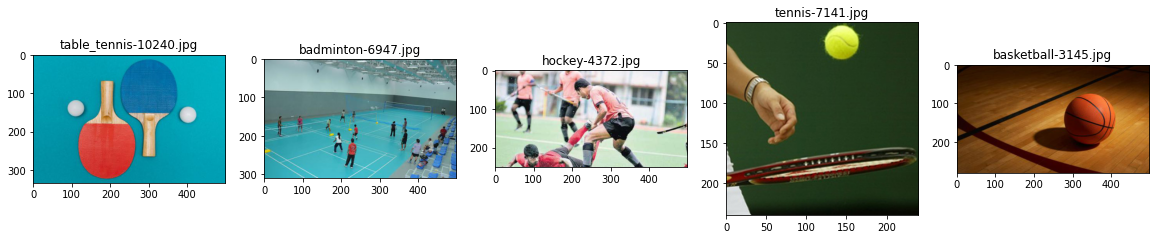

In [8]:
# Printing random five images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(data_path))
    image_path = os.path.join(data_path, file)
    image_details = image_df[image_df['file'] == file]
    image_label = image_details.iloc[0]['label']
    label_name = []
    for key, value in labels.items():
        if value == image_label:
            label_name.append(key)
    image_name = label_name[0]
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(str(image_name)+"-"+str(file))
    plt.imshow(img)

In [9]:
# results run from the model using SGD as an optimizer
sgd_results = pd.read_csv('sgd.csv')
# results run from the model using Adam as an optimizer
adam_results = pd.read_csv('adam.csv')

# show the results of the models ran with this data
model_results = pd.concat([sgd_results,adam_results],
                          ignore_index=True).sort_values(by=['Accuracy'],
                                                         ascending=False).reset_index(drop = True)

model_results.head(10)

,Model_Type,Optimization,Accuracy
0,VGG16,Adam,0.616667
1,VGG16,SGD,0.596739
2,Simple CNN,Adam,0.426449
3,CNN w/Dropout,Adam,0.413768
4,CNN with Dropout and Data Augmention,Adam,0.326087
5,Simple NN,Adam,0.324638
6,Simple NN Dropout,SGD,0.321014
7,Simple NN,SGD,0.314855
8,Simple NN Dropout,Adam,0.314855
9,Simple NN L2 Reg,SGD,0.313406


Based on the results from the above test modeling, I am going to run my model using a Convolutional Neural Network with Pretrained Covnet (VGG16) and Adam as an optimizer and with a learning rate of 0.0001

In [20]:
# create a function that transforms the features fit for a Convolutional Neural Network

def cnn_features(df):

    eighty = int(len(df)*0.80)
    twenty = int(len(df)*0.20)
    # split the df 80%-20%
    train_df = df[:eighty]
    test_df = df[eighty:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape(((len(train_df), 64, 64, 3)))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape(((len(test_df), 64, 64, 3)))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)
    # create a validation set
    image_val = train_images[:1000]
    partial_image_train = train_images[1000:]
    
    label_val = train_labels[:1000]
    partial_label_train = train_labels[1000:]
    
    return image_val, partial_image_train, label_val, partial_label_train


# create a function that transforms the features fit for a testing a Convolutional Neural Network

def cnn_eval_features(df):

    eighty = int(len(df)*0.80)
    twenty = int(len(df)*0.20)
    # split the df 80%-20%
    train_df = df[:eighty]
    test_df = df[eighty:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape(((len(train_df), 64, 64, 3)))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape(((len(test_df), 64, 64, 3)))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)

    
    return train_images, train_labels, test_images, test_labels

In [21]:
# Convolutional Neural Network with Pretrained Covnet (VGG16) Fine Tuning

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(23, activation = 'softmax'))

train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(partial_image_train, partial_label_train, batch_size=20)



model.compile(optimizer=optimizers.Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, steps_per_epoch=100, epochs=30,
                    validation_data = (image_val, label_val))

Epoch 1/30
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 19.9600 - loss: 2.7803 - accuracy: 0.2009WARNING:tensorflow:From /Users/kenny/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
100/100 [==============================] - 110s 1s/step - batch: 49.5000 - size: 19.9600 - loss: 2.7803 - accuracy: 0.2009 - val_loss: 2.3748 - val_accuracy: 0.2950
Epoch 2/30
100/100 [==============================] - 113s 1s/step - batch: 49.5000 - size: 20.0000 - loss: 2.2590 - accuracy: 0.3340 - val_loss: 2.0205 - val_accuracy: 0.3860
Epoch 3/30
100/100 [==============================] - 111s 1s/step - batch: 49.5000 - size: 20.0000 - loss: 2.0622 - accuracy: 0.3970 - val_loss: 1.9765 - val_ac

In [22]:
# set up a webdriver to scrap images

options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome("/Users/kenny/Data Science/chromedriver", options=options)

In [23]:
def click_more_button(url):
    driver.get(url)
    more_buttons = driver.find_elements_by_class_name("m-button")
    for x in range(len(more_buttons)):
        if more_buttons[x].is_displayed():
            driver.execute_script("arguments[0].click();", more_buttons[x])
            time.sleep(1)

    page_source = driver.page_source
    
    return page_source

def image_urls(url):

        page_source = click_more_button(url)
        
        soup = BeautifulSoup(page_source, 'html.parser')
        
        for item in soup.find_all('img'):
            image_url_list.append(item['src'])


In [24]:
image_url_list = []

source_urls = ['https://vault.si.com/vault/archives/2010s/2019',
              'https://vault.si.com/vault/archives/2010s/2018',
              'https://vault.si.com/vault/archives/2010s/2017',
              'https://vault.si.com/vault/archives/2010s/2016',
              'https://vault.si.com/vault/archives/2010s/2015',
              'https://vault.si.com/vault/archives/2010s/2014',
              'https://vault.si.com/vault/archives/2010s/2013',
              'https://vault.si.com/vault/archives/2010s/2012',
              'https://vault.si.com/vault/archives/2010s/2011',
              'https://vault.si.com/vault/archives/2010s/2010']


for url in source_urls:
    image_urls(url)
    
    
filter_df = pd.DataFrame(image_url_list, columns = ['source'])

https = []
for url in filter_df['source']:
    header = url[:6]
    https.append(header)
    
jpg = []
for url in filter_df['source']:
    image_type = url[-3:]
    jpg.append(image_type)
    
filter_df['https'] = https
filter_df['jpg'] = jpg
filtered_https = filter_df[filter_df['https'] == 'https:']
filtered_https = filtered_https[filtered_https['jpg'] == 'jpg']
filtered_image_list = filtered_https['source'].tolist()

In [25]:
def save_images(url):
    ## Set up the image URL and filename
    parent_dir = Path(os.getcwd()).absolute()
    image_dir = Path(os.path.join(parent_dir,'SI_covers'))
    image_dir.mkdir(exist_ok=True)
    filename = url.split("/")[-1]
    dest = Path(os.path.join(image_dir, filename))

    # Open the url image, set stream to True, this will return the stream content.
    r = requests.get(url, stream = True)

    # Check if the image was retrieved successfully
    if r.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True

        # Open a local file with wb ( write binary ) permission.
        with open(dest,'wb') as f:
            shutil.copyfileobj(r.raw, f)

        print('Image sucessfully Downloaded: ',filename)
    else:
        print('Image Couldn\'t be retreived')

In [6]:
for url in filtered_image_list:
    save_images(url)

Image sucessfully Downloaded:  1019245---cover-image.jpg
Image sucessfully Downloaded:  1019195---cover-image.jpg
Image sucessfully Downloaded:  1019191---cover-image.jpg
Image sucessfully Downloaded:  1018465---cover-image.jpg
Image sucessfully Downloaded:  1019161---cover-image.jpg
Image sucessfully Downloaded:  1019146---cover-image.jpg
Image sucessfully Downloaded:  1019130---cover-image.jpg
Image sucessfully Downloaded:  1019117---cover-image.jpg
Image sucessfully Downloaded:  1019099---cover-image.jpg
Image sucessfully Downloaded:  1019086---cover-image.jpg
Image sucessfully Downloaded:  1019064---cover-image.jpg
Image sucessfully Downloaded:  1019045---cover-image.jpg
Image sucessfully Downloaded:  1019001---cover-image.jpg
Image sucessfully Downloaded:  1018941---cover-image.jpg
Image sucessfully Downloaded:  1018940---cover-image.jpg
Image sucessfully Downloaded:  1018939---cover-image.jpg
Image sucessfully Downloaded:  1018884---cover-image.jpg
Image sucessfully Downloaded:  

Image sucessfully Downloaded:  1010928---cover-image.jpg
Image sucessfully Downloaded:  1010927---cover-image.jpg
Image sucessfully Downloaded:  1010926---cover-image.jpg
Image sucessfully Downloaded:  1010925---cover-image.jpg
Image sucessfully Downloaded:  1010924---cover-image.jpg
Image sucessfully Downloaded:  1010923---cover-image.jpg
Image sucessfully Downloaded:  1010922---cover-image.jpg
Image sucessfully Downloaded:  1010921---cover-image.jpg
Image sucessfully Downloaded:  1010920---cover-image.jpg
Image sucessfully Downloaded:  1010919---cover-image.jpg
Image sucessfully Downloaded:  1010918---cover-image.jpg
Image sucessfully Downloaded:  1010917---cover-image.jpg
Image sucessfully Downloaded:  1010916---cover-image.jpg
Image sucessfully Downloaded:  1010915---cover-image.jpg
Image sucessfully Downloaded:  1010914---cover-image.jpg
Image sucessfully Downloaded:  1012068---cover-image.jpg
Image sucessfully Downloaded:  1010913---cover-image.jpg
Image sucessfully Downloaded:  

In [26]:
si_labels = pd.DataFrame(filtered_image_list, columns = ['url'])

images = []
for url in si_labels['url']:
    image = url.split("/")[-1]
    images.append(image)

si_labels['image'] = images
si_labels = si_labels.drop('url', axis=1)
si_labels.head()

,image
0,1019245---cover-image.jpg
1,1019195---cover-image.jpg
2,1019191---cover-image.jpg
3,1018465---cover-image.jpg
4,1019161---cover-image.jpg


In [54]:
si_labels = pd.read_csv('si_labels.csv')
si_label_dict = pd.Series(si_labels.label.values,index=si_labels.image).to_dict()
si_labels = si_labels[si_labels['label'] != 'Unknown']
si_labels['label_number'] = si_labels['label'].map(labels)
si_labels['file'] = si_labels['image']

# create a dict of the files and their corresponding numeric label
si_file_dict = pd.Series(si_labels.label_number.values,index=si_labels.file).to_dict()

si_labels.head()

,image,label,label_number,file
0,1006822---cover-image.jpg,tennis,17,1006822---cover-image.jpg
1,1006823---cover-image.jpg,basketball,2,1006823---cover-image.jpg
2,1006824---cover-image.jpg,American football,22,1006824---cover-image.jpg
3,1006825---cover-image.jpg,baseball,1,1006825---cover-image.jpg
4,1006827---cover-image.jpg,American football,22,1006827---cover-image.jpg


In [58]:
si_data_path = Path(os.path.join(parent_dir,'SI_covers'))

# run the image transformation function on the images
si_image_attributes = create_dataset(si_data_path, 64, 64)

# create a dataframe of the file name and transformed images
si_image_df = pd.DataFrame(si_image_attributes, columns = ['file','image'])
# add a label column of the numeric label for each image
si_image_df['sport'] = si_image_df['file'].map(si_label_dict)
si_image_df = si_image_df[si_image_df['sport'] != 'Unknown']
si_image_df['label'] = si_image_df['file'].map(si_file_dict)
si_image_df.head()

,file,image,sport,label
0,1006842---cover-image.jpg,"[[[153, 158, 180], [168, 171, 191], [123, 126,...",American football,22
2,1015969---cover-image.jpg,"[[[40, 20, 5], [51, 25, 4], [77, 42, 2], [63, ...",baseball,1
3,1010913---cover-image.jpg,"[[[0, 4, 54], [0, 4, 54], [0, 4, 54], [1, 4, 5...",baseball,1
4,1008508---cover-image.jpg,"[[[100, 117, 134], [90, 101, 118], [94, 107, 1...",basketball,2
6,1019130---cover-image.jpg,"[[[53, 54, 90], [81, 79, 99], [127, 125, 124],...",football,7


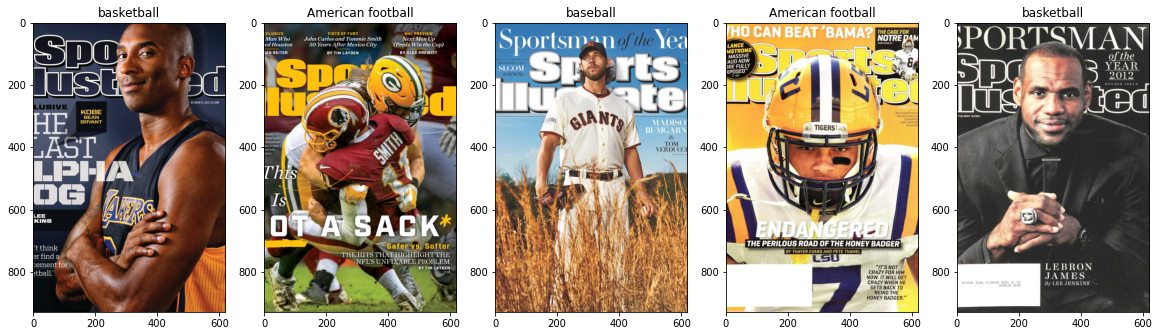

In [61]:
# Printing random five images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(si_data_path))
    image_path = os.path.join(si_data_path, file)
    image_details = si_image_df[si_image_df['file'] == file]
    image_label = image_details.iloc[0]['label']
    label_name = []
    for key, value in labels.items():
        if value == image_label:
            label_name.append(key)
    image_name = label_name[0]
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(str(image_name))
    plt.imshow(img)

In [65]:
# Evaluate Convolutional Neural Network with Pretrained Covnet (VGG16) on the SI Covers

test_images = []
for array in si_image_df['image']:
    test_images.append(array)

test_images = np.array(test_images)
test_images = test_images.reshape(((len(si_image_df), 64, 64, 3)))
test_images = test_images.astype('float32') / 255
# create a list of the train and test labels

test_labels  = np.array(si_image_df['label'])
test_labels = to_categorical(test_labels)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', "{:.0%}".format(test_acc))
print('test_loss:', round(test_loss,2))

test_acc: 28%
test_loss: 2.98
